# Untitled Supermarked Project
## Queuing Simulator
This Queuing Simulator can be used to simulate a wide variety of  situations and is therefore quite flexible. It's structure however, is heavily tailored to the needs of the dataset.<br>
This notebook visualizes the uses of the function. For the main Jupyter Notebook, a .py file is used to import the functions.

### Setting Up Workshop

In [97]:
# DataFrames
import pandas as pd
# Visualizations
import matplotlib.pyplot as plt
# Statistics
from scipy import stats 
# Array and Array Math
import numpy as np

### Simulating a Queuing System
<img src="https://upload.wikimedia.org/wikipedia/commons/6/65/Mm1_queue.svg"/>
In queuing theory a basic queuing system consists of customers an arrival process, service station (which follow a service process) and the resulting queue. The waiting is the result of an arrival while the station is busy serving a customer.<br>
The entry-process is a stochastic process, meaning that the time between each arrival is determined by a random variable. The service-process determines similary the time needed to service a customer. After the service, the customer leaves the system.
There can be more than one station:
<img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Queueing_node_service_digram.png"/>
Therefore, in order to set up a basic queuing system, one needs to determine:<br>
- the entry process,<br>
- the service process, and<br>
- the number of stations.

#### Python Functions
<u>Entry Process:</u> Determined by random variable via a scipy.stats object (entry_variable) and its parameters (entry_variable_parameters).<br>
<u>Service Process:</u> Is determined by a random variable and parameters (service_variable, service_variable_paramenter).<br>
<u>Number of Stations:</u> Is derived from "shifts", in order to process the information from the dataset directly. Shifts will be a list of tupels, comprising of the beginning and the end of the shift. Examples:<br>
- One Station: [(0,np.nan)], meaning a shift that starts at 0 and ends at the end of the run.<br>
- Two Stations: [(0,np.nan),(0,np.nan)].<br>

In [98]:
# Random generates an Entry-Process (= "the time a customer enters the waiting area")
def entry_process(customers, entry_variable, entry_variable_parameters):
    # Set up Collector for results
    results          = pd.DataFrame([])
    # Generates randomly how much time passes between Customers
    results["time"]  = entry_variable(** entry_variable_parameters, size = customers)
    # Sum up to determine entry time of each customer
    results["entry"] = results.time.cumsum()
    # Return results
    return results["entry"]

In [99]:
demo_arrival = entry_process(customers                 = 5,
                             entry_variable            = stats.expon.rvs,
                             entry_variable_parameters = {"loc" : 0, "scale" : 1, "random_state" : 0})
print(example_arrival)

0    0.795875
1    2.051805
2    2.975028
3    3.762230
4    4.313278
Name: entry, dtype: float64


In [100]:
# Random-generates the the service-process and the resulting exit-process
# (= "the time a customer gets to/ leaves the cashier")
def service_process(entries, service_variable, service_variable_parameters, shifts):
    # Turn Shifts into Stations
    stations = np.array(shifts, dtype=[('ready', '<f8'), ('close', '<f8')])
    # Set up Collectors for Results
    results_service = ([])
    results_station = ([])
    results_exit    = ([]) 
    # Cycle through Customers of the Entry-Process
    for idx in entries:      
        # Index of next available Station
        # (Customer chooses Station which has been unoccupied the longest)
        free = np.nanmin(np.argwhere(stations["ready"] == np.nanmin(stations["ready"])))
        # Add Time when Customer starts being serviced 
        results_service.append(max(idx,stations["ready"][free])) 
        # Generate time when Customer is done
        done = float(max(idx,stations["ready"][free]) + service_variable(** service_variable_parameters, size = 1))
        # Add Time when Customer is done/ leaves the register
        results_exit.append(done)
        # Add used Station
        results_station.append(free)
        # Check if shift is over and Station can be closed
        if(stations["close"][free] <= done):
            # Close Station
            stations["ready"][free] = np.nan
        else:
            # Update Station's Ready Time
            stations["ready"][free] = done   
    # Return results
    return results_service, results_exit, results_station

In [101]:
service_process(entries                     = demo_arrival,
                service_variable            = stats.expon.rvs,
                service_variable_parameters = {"loc" : 0, "scale" : 1, "random_state" : 1},
                shifts                      = [(0,np.nan),(0,np.nan)])

([0.79587450816311,
  2.0518052711289476,
  2.9750284169330166,
  3.7622295692502874,
  4.3132780603457865],
 [1.3354803454222954,
  2.591411108388133,
  3.514634254192202,
  4.301835406509473,
  4.852883897604972],
 [0, 1, 0, 1, 0])

In [102]:
# Simulate Queue by combining entry_process and service_process, and returning the relevant data in a dataframe
def makeq(n_customers,
          entry_variable,entry_variable_parameters,
          service_variable,service_variable_parameters,
          shifts):
    # Set Up Collector for Results
    overview                              = pd.DataFrame([])
    # Random Generate Entrance of Customers
    overview["entry"]                     = entry_process(n_customers,
                                                          entry_variable,
                                                          entry_variable_parameters)
    # Random Generate Service/ Exit of Customers
    overview["service"], overview["exit"], overview["station"] = service_process(overview["entry"], 
                                                                                 service_variable,
                                                                                 service_variable_parameters, 
                                                                                 shifts)
    # Return resulting Dataframe
    return(overview)

In [103]:
makeq(n_customers                 = 5,
      entry_variable              = stats.expon.rvs,
      entry_variable_parameters   = {"loc" : 0, "scale" : 1, "random_state" : 0},
      service_variable            = stats.expon.rvs,
      service_variable_parameters = {"loc" : 0, "scale" : 1, "random_state" : 1},
      shifts                      = [(0,np.nan),(0,np.nan)])

,entry,service,exit,station
0,0.795875,0.795875,1.335480,0
1,2.051805,2.051805,2.591411,1
2,2.975028,2.975028,3.514634,0
3,3.762230,3.762230,4.301835,1
4,4.313278,4.313278,4.852884,0


#### Test Runs
The test runs will be named using the Kendall Notation: Entry Process/ Service Process/ Number of Stations.<br>
<i>M</i> means the time between arrivals is exponential-random distributed. $ \lambda $ is the arrival rate, $ \mu $ the service rate. You can find explanations on the Kendall Notation [here](https://en.wikipedia.org/wiki/Kendall%27s_notation).

##### M/M/1 Queue
- $ \lambda $ : 1
- $ \mu $ : 1

In [104]:
title                       = "M/M/1 - Queue"
n_customers                 = 100
entry_variable              = stats.expon.rvs
entry_variable_parameters   = {"loc" : 0, "scale" : 1, "random_state" : 0}
service_variable            = stats.expon.rvs
service_variable_parameters = {"loc" : 0, "scale" : 1, "random_state" : 0}
shifts                      = [(0,np.nan)]

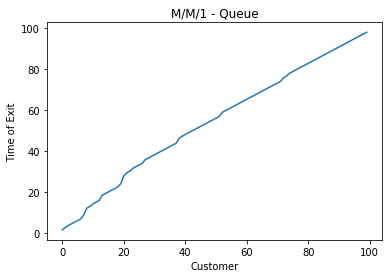

In [105]:
# Gernerate Data
example = makeq(n_customers,
                entry_variable,   entry_variable_parameters,
                service_variable, service_variable_parameters,
                shifts)
# Plot Results
plt.title(title)
plt.plot(example.exit)
plt.ylabel("Time of Exit")
plt.xlabel("Customer")
plt.show()

#### M/M/2 Queue
- $ \lambda $ : 1
- $ \mu $ : 1

In [106]:
title                       = "M/M/2 - Queue"
n_customers                 = 100
entry_variable              = stats.expon.rvs
entry_variable_parameters   = {"loc" : 0, "scale" : 1, "random_state" : 0}
service_variable            = stats.expon.rvs
service_variable_parameters = {"loc" : 0, "scale" : 1, "random_state" : 0}
shifts                      = [(0,np.nan),(0,np.nan)]

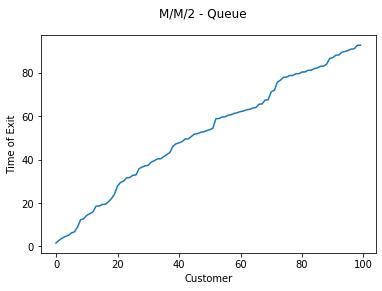

In [107]:
# Gernerate Data
example = makeq(n_customers,
                entry_variable, entry_variable_parameters,
                service_variable,service_variable_parameters,
                shifts)
# Plot Results
plt.suptitle(title)
plt.plot(example.exit)
plt.ylabel("Time of Exit")
plt.xlabel("Customer")
plt.show()

#### M/M/c(t) Queue
- $ \lambda $ : 2
- $ \mu $ : 1
- <b>c(t)</b> : 1 for t <= 20 and t >= 40, 2 for t > 20 and t < 40

In [108]:
title                       = "M/M/c(t) - Queue"
n_customers                 = 100
entry_variable              = stats.expon.rvs
entry_variable_parameters   = {"loc" : 0, "scale" : 2, "random_state" : 0}
service_variable            = stats.expon.rvs
service_variable_parameters = {"loc" : 0, "scale" : 1, "random_state" : 0}
shifts                      = [(0,np.nan),(20,40)]

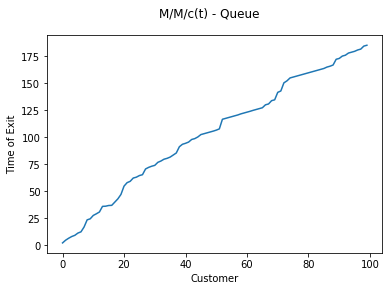

In [109]:
# Gernerate Data
example = makeq(n_customers,
                entry_variable, entry_variable_parameters,
                service_variable,service_variable_parameters,
                shifts)
# Plot Results
plt.suptitle(title)
plt.plot(example.exit)
plt.ylabel("Time of Exit")
plt.xlabel("Customer")
plt.show()

### Monte Carlo Studies 

#### Functions

In [110]:
# Make a set, which stores the relevant results (exit time of each costumer) from multiple queuing simulation runs
def alotta_queues (runs,
                 n_customers, entry_variable, entry_variable_parameters,
                 service_variable, service_variable_parameters, shifts):
    # Set up Collector for results
    exits = pd.DataFrame([])
    # Runs multiple Queing Simulations
    for idx in range(1,runs+1):    
        exits = exits.append(makeq(n_customers, entry_variable, entry_variable_parameters,
                                  service_variable, service_variable_parameters, shifts).exit)
    return exits

In [111]:
runs                        = 1000
title                       = "M/M/1 - Queue"
n_customers                 = 100
entry_variable              = stats.expon.rvs
entry_variable_parameters   = {"loc" : 0, "scale" : 0.1}
service_variable            = stats.expon.rvs
service_variable_parameters = {"loc" : 0, "scale" : 1}
shifts                      = [(0,np.nan),(25,np.nan)]

In [112]:
example = alotta_queues(runs,
                 n_customers,entry_variable,entry_variable_parameters,
                 service_variable,service_variable_parameters,shifts)
example.index = range(0,runs)

#### Test Runs

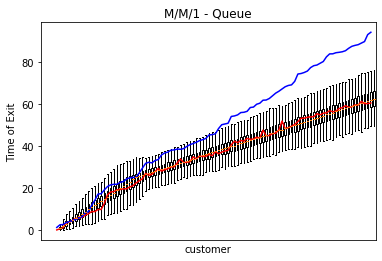

In [113]:
plt.title(title)
plt.ylabel("Time of Exit")
plt.xlabel("customer")
plt.tick_params(
    axis        = 'x',
    which       = 'both',
    bottom      = False,
    top         = False,
    labelbottom = False)
plt.boxplot(example.T, showfliers = False)

exampleq = makeq(n_customers,
                entry_variable, entry_variable_parameters,
                service_variable,service_variable_parameters,
                [(0,np.nan),(25,np.nan)])
# Plot Results
plt.plot(exampleq.exit, color = "red")


entry_variable_parameters   = {"loc" : 0, "scale" : 1}
service_variable_parameters = {"loc" : 0, "scale" : 0.1}


exampleq = makeq(n_customers,
                entry_variable, entry_variable_parameters,
                service_variable,service_variable_parameters,
                [(0,np.nan),(25,np.nan)])
# Plot Results
plt.plot(exampleq.exit, color = "blue")

plt.show()

### Construction Site

In [ ]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = False)
ax1.scatter(y = example.exit, x = example.entry)
ax1.set_xlabel("entry time")
ax1.set_ylabel("exit time")
ax2.scatter(y = (example.exit-example.entry), x = example.entry)
ax2.set_xlabel("entry time")
ax2.set_ylabel("waiting time")
ax3.plot(example.exit)
ax3.set_xlabel("customer")
ax3.set_ylabel("exit time")
plt.show()

In [ ]:
plt.suptitle(title)
plt.title("No Wait vs Wait")
plt.pie([((example.service - example.entry) == 0).sum(),
         ((example.service - example.entry) != 0).sum()],
       labels = ["No Wait","Wait"])
plt.show()

In [ ]:
waiting_times = example.service - example.entry
plt.suptitle(title)
plt.title("Waiting Time Distribution")
plt.ylabel("Count")
plt.xlabel("Waiting Times in Seconds")
plt.hist(waiting_times[waiting_times>0])
plt.show()

In [ ]:
plt.suptitle(title)
plt.scatter(y = (example.service-example.entry), x = example.entry, c = example.station)
plt.ylabel("Waiting Time")
plt.xlabel("Time of Entry")
plt.show()

## Sorces
- Images: Wikipedia

## Future Works
### Queue Generator:
- Non Stationary Entry-Process<br>
- Non Stationary Service-Process<br>
- Offer Choice to end QueueSim after specific time passed vs specific number of customers<br>
- Multiplot for Analysis (EntryTime/ Exit Time; EntryTime/ Waiting Time; Customer/ Exittime)<br>

### Monte Carlo Simulation:
- Compare Results to known result<br>
- Validate Queue Generator<br>
- Analyze Results<br>
- Compare Results to actual case<br>
- Select Number of runs vs desired accuracy of results<br>

### General
- Export Functions to .py<br>
- Consider List vs Numpy vs Pandas<br>
- Consider Object-Oriented approach<br>